In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/envs/deeplearningproject3/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deeplearningproject3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/deeplearningproject3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deeplearningproject3/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject3/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject3/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject3/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3607843117713928..1.0000000236034394].


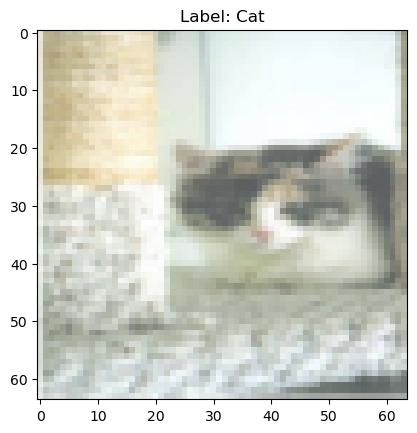

In [3]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Custom Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        # Subset: First 2000 images to keep it manageable
        self.images = self.images[:2000]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        label = 0 if 'cat' in self.images[idx] else 1  # 0 = cat, 1 = dog
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset (download from Kaggle manually first)
data_dir = './data/train'  # Extract train.zip from Kaggle here
full_dataset = CatsDogsDataset(root_dir=data_dir, transform=None)

# Train/validation/test split (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f'Label: {"Cat" if labels[0].item() == 0 else "Dog"}')
plt.show()

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 input channels (RGB), 16 filters
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Binary output

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet().to(device)

Epoch [1/20], Train Loss: 0.6985, Val Loss: 0.6864
Epoch [2/20], Train Loss: 0.6621, Val Loss: 0.6565
Epoch [3/20], Train Loss: 0.6123, Val Loss: 0.6168
Epoch [4/20], Train Loss: 0.5764, Val Loss: 0.6144
Epoch [5/20], Train Loss: 0.5153, Val Loss: 0.5994
Epoch [6/20], Train Loss: 0.4797, Val Loss: 0.6121
Epoch [7/20], Train Loss: 0.4144, Val Loss: 0.6054
Epoch [8/20], Train Loss: 0.3369, Val Loss: 0.6495
Epoch [9/20], Train Loss: 0.2695, Val Loss: 0.6731
Epoch [10/20], Train Loss: 0.2074, Val Loss: 0.7689
Epoch [11/20], Train Loss: 0.1542, Val Loss: 0.8191
Epoch [12/20], Train Loss: 0.1312, Val Loss: 0.8710
Epoch [13/20], Train Loss: 0.0918, Val Loss: 0.9313
Epoch [14/20], Train Loss: 0.0489, Val Loss: 1.0021
Epoch [15/20], Train Loss: 0.0310, Val Loss: 1.1160
Epoch [16/20], Train Loss: 0.0218, Val Loss: 1.2077
Epoch [17/20], Train Loss: 0.0131, Val Loss: 1.2460
Epoch [18/20], Train Loss: 0.0091, Val Loss: 1.3582
Epoch [19/20], Train Loss: 0.0066, Val Loss: 1.3355
Epoch [20/20], Train 

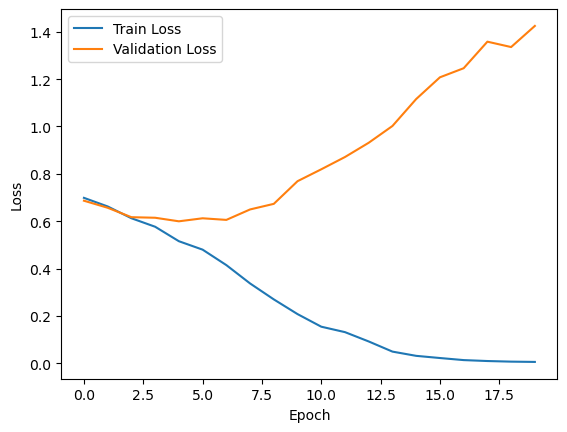

In [5]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 70.33%
